In [1]:
%cd /home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger-detection/BGN-ST

/home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger-detection/BGN-ST


In [2]:
import torch
import pickle
import dataloaders
import matplotlib.pyplot as plt
from utils.log import load_checkpoint
from collections import defaultdict
from itertools import islice
from tqdm.notebook import tqdm
from models.Bipartite_Attention_Masked import Bipartite_Attention as Model
import matplotlib as mpl
import torch.nn as nn
import numpy as np
import random
import glob
from itertools import product

In [3]:
# System imports
import os

# External imports
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, random_split
import torch_geometric
import random

from collections import namedtuple
import dataclasses

@dataclasses.dataclass
class EventInfo:
    hit_cartesian: np.ndarray
    hit_cylindrical: np.ndarray
    layer_id: np.ndarray
    n_pixels: np.ndarray
    energy: np.ndarray
    momentum: np.ndarray
    interaction_point: np.ndarray
    trigger: np.ndarray
    has_trigger_pair: np.ndarray
    track_origin: np.ndarray
    edge_index: np.ndarray
    edge_z0: np.ndarray
    edge_phi_slope: np.ndarray
    phi_slope_max: float
    z0_max: float
    trigger_node: np.ndarray
    particle_id: np.ndarray
    particle_type: np.ndarray
    parent_particle_type: np.ndarray
    active_node: np.ndarray

def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    return dphi


def build_edges(event_info, phi_slope_max, z0_max):
    r, phi, z  = event_info.hit_cylindrical.T
    layer_pairs = [(0,1), (1,2), (2,3), (3,4), (4,5), (5,6), (1, 3), (1,4), (2,4), (2,5), (3,5), (3,6), (4,6)]
    hit_ids = np.arange(len(event_info.hit_cylindrical))
    edge_candidates = []
    phi_slopes = []
    z0s = []
    layer_id = event_info.layer_id
    for (layer1, layer2) in layer_pairs:
        mask1 = layer_id == layer1
        mask2 = layer_id == layer2
        if np.sum(mask1) == 0 or np.sum(mask2) == 0:
            continue
        h1 = hit_ids[mask1]
        h2 = hit_ids[mask2]
        edges = np.stack(np.meshgrid(h1, h2, indexing='xy'), axis=-1).reshape(-1, 2)

        z1 = z[mask1]
        z2 = z[mask2]
        r1 = r[mask1]
        r2 = r[mask2]
        phi1 = phi[mask1]
        phi2 = phi[mask2]

        dphi = calc_dphi(phi2.reshape(-1, 1), phi1.reshape(1, -1))
        dr = r2.reshape(-1, 1) - r1.reshape(1, -1)
        dz = z2.reshape(-1, 1) - z1.reshape(1, -1)
        phi_slope = dphi / dr
        z0 = z1 - r1 * dz / dr
        good_seg_mask = (np.abs(phi_slope) <= phi_slope_max) & (np.abs(z0) <= z0_max)
        good_seg_mask = good_seg_mask.reshape(-1)
        edge_candidates.append(edges[good_seg_mask])
        phi_slopes.append(phi_slope.reshape(-1)[good_seg_mask])
        z0s.append(z0.reshape(-1)[good_seg_mask])

    return np.concatenate(edge_candidates, axis=0).T, np.concatenate(phi_slopes), np.concatenate(z0s)

def load_file(filename):
    with np.load(filename, allow_pickle=True) as f:
        return EventInfo(
                hit_cartesian=f['hit_cartesian'],
                hit_cylindrical=f['hit_cylindrical'],
                layer_id=f['layer_id'],
                n_pixels=f['n_pixels'],
                energy=f['energy'],
                momentum=f['momentum'],
                interaction_point=f['interaction_point'],
                trigger=f['trigger'],
                has_trigger_pair=f['has_trigger_pair'],
                track_origin=f['track_origin'],
                edge_index=f['edge_index'],
                edge_z0=f['edge_z0'],
                edge_phi_slope=f['edge_phi_slope'],
                phi_slope_max=f['phi_slope_max'],
                z0_max=f['z0_max'],
                trigger_node=f['trigger_node'],
                particle_id=f['particle_id'],
                particle_type=f['particle_type'],
                parent_particle_type=f['parent_particle_type'],
                active_node=np.ones(f['hit_cartesian'].shape[0], dtype=int)
        )




def load_graph(filename, cylindrical_features_scale, phi_slope_max, z0_max, use_intt):
    event_info = load_file(filename)

    if not use_intt:
        keep = event_info.layer_id <= 2
    else:
        keep = np.ones(event_info.layer_id.shape[0])


    x = np.concatenate([
        event_info.hit_cylindrical/cylindrical_features_scale[None],
        event_info.n_pixels.reshape(-1, 1), 
        event_info.layer_id.reshape(-1, 1)
    ], axis=-1)[keep]



    edge_index = event_info.edge_index
    phi_slope = event_info.edge_phi_slope
    z0 = event_info.edge_z0
    edge_index = edge_index[:, (np.abs(phi_slope) <= phi_slope_max) & (np.abs(z0) <= z0_max)]
    pid = event_info.particle_id
    keep_edge = keep[edge_index[0]] & keep[edge_index[1]]

    edge_index = edge_index[:, keep_edge]

    y = pid[edge_index[0]] == pid[edge_index[1]]

    event_info.edge_index = edge_index

    event_info.edge_phi_slope = (phi_slope[(np.abs(phi_slope) <= phi_slope_max) & (np.abs(z0) <= z0_max)])[keep_edge]
    event_info.edge_z0 = (z0[(np.abs(phi_slope) <= phi_slope_max) & (np.abs(z0) <= z0_max)])[keep_edge]
    event_info.phi_slope_max = phi_slope_max
    event_info.z0_max = z0_max


    return x, edge_index, y, event_info



def multi_load_graph(intt_filename, filenames, noise_filenames, cylindrical_features_scale, phi_slope_max, z0_max, use_intt, n_noise_intt=3, construct_edges=True):
    event_info_list = [load_file(intt_filename)] + [load_file(filename) for filename in filenames]
    noise_event_info_list = [load_file(filename) for filename in noise_filenames]
    max_pid = np.max(event_info_list[0].particle_id)
    start_index = 1 if use_intt else 0
    i = 0
    for event_info in event_info_list[start_index:]:
        # Node mask
        mask = event_info.layer_id < 3
        event_info.hit_cartesian = event_info.hit_cartesian[mask]
        event_info.hit_cylindrical = event_info.hit_cylindrical[mask]
        event_info.layer_id = event_info.layer_id[mask]
        event_info.n_pixels = event_info.n_pixels[mask]
        event_info.momentum = event_info.momentum[mask]
        event_info.energy = event_info.energy[mask]
        event_info.particle_id = event_info.particle_id[mask] + max_pid
        event_info.track_origin = event_info.track_origin[mask]
        max_pid = np.max(event_info.particle_id)
        event_info.particle_type = event_info.particle_type[mask]
        event_info.parent_particle_type = event_info.parent_particle_type[mask]
        event_info.trigger_node = event_info.trigger_node[mask]
        event_info.active_node = event_info.active_node[mask]*(i == start_index and not use_intt)

    for i, event_info in enumerate(noise_event_info_list):
        # Node mask
        mask = np.ones(event_info.hit_cartesian.shape[0], dtype=bool)
        event_info.hit_cartesian = event_info.hit_cartesian[mask]
        event_info.hit_cylindrical = event_info.hit_cylindrical[mask]
        event_info.layer_id = event_info.layer_id[mask]
        event_info.n_pixels = np.floor(np.random.exponential(size=mask.shape)+1).astype(np.int)
        event_info.momentum = np.nan*np.ones_like(event_info.momentum)
        event_info.energy = np.nan*np.ones_like(event_info.energy)
        event_info.particle_id = np.nan*np.ones_like(event_info.particle_id)
        event_info.track_origin = np.nan*np.ones_like(event_info.track_origin)
        event_info.particle_type = np.nan*np.ones_like(event_info.particle_type)
        event_info.parent_particle_type = np.nan*np.ones_like(event_info.parent_particle_type)
        event_info.trigger_node = np.zeros_like(event_info.trigger_node)
        event_info.active_node = np.zeros_like(event_info.active_node)
        

    noise_event_info = EventInfo(
            hit_cartesian=np.concatenate([event_info.hit_cartesian for event_info in noise_event_info_list], axis=0),
            hit_cylindrical=np.concatenate([event_info.hit_cylindrical for event_info in noise_event_info_list], axis=0),
            track_origin=np.concatenate([event_info.track_origin for event_info in noise_event_info_list], axis=0),
            layer_id=np.concatenate([event_info.layer_id for event_info in noise_event_info_list], axis=0),
            n_pixels=np.concatenate([event_info.n_pixels for event_info in noise_event_info_list], axis=0),
            energy=np.concatenate([event_info.energy for event_info in noise_event_info_list], axis=0),
            momentum=np.concatenate([event_info.momentum for event_info in noise_event_info_list], axis=0),
            interaction_point=noise_event_info_list[0].interaction_point,
            trigger=False,
            has_trigger_pair=noise_event_info_list[0].has_trigger_pair,
            particle_id=np.concatenate([event_info.particle_id for event_info in noise_event_info_list], axis=0),
            particle_type=np.concatenate([event_info.particle_type for event_info in noise_event_info_list], axis=0),
            parent_particle_type=np.concatenate([event_info.parent_particle_type for event_info in noise_event_info_list], axis=0),
            trigger_node=np.concatenate([event_info.trigger_node for event_info in noise_event_info_list], axis=0),
            active_node=np.concatenate([event_info.active_node for event_info in noise_event_info_list], axis=0),
            edge_index=None,
            edge_z0=None,
            edge_phi_slope=None,
            phi_slope_max=phi_slope_max,
            z0_max=z0_max
        )


    
    n_mvtx_noise = np.random.binomial(n=1572864*len(event_info_list), p=1e-6)
    n_noise_intt = int(np.floor(np.random.exponential()+n_noise_intt))
    mvtx_noise_hits = np.where(noise_event_info.layer_id < 3)[0]
    intt_noise_hits = np.where(noise_event_info.layer_id >= 3)[0]
    np.random.shuffle(mvtx_noise_hits)
    np.random.shuffle(intt_noise_hits)
    mvtx_noise_hits = mvtx_noise_hits[:n_mvtx_noise]
    intt_noise_hits = intt_noise_hits[:n_noise_intt]

    mask = np.zeros(noise_event_info.hit_cartesian.shape[0], dtype=bool)
    mask[mvtx_noise_hits] = 1
    if use_intt:
        mask[intt_noise_hits] = 1

    noise_event_info.hit_cartesian = noise_event_info.hit_cartesian[mask]
    noise_event_info.hit_cylindrical = noise_event_info.hit_cylindrical[mask]
    noise_event_info.track_origin = noise_event_info.track_origin[mask]
    noise_event_info.layer_id = noise_event_info.layer_id[mask]
    noise_event_info.n_pixels = noise_event_info.n_pixels[mask]
    noise_event_info.energy = noise_event_info.energy[mask]
    noise_event_info.momentum = noise_event_info.momentum[mask]
    noise_event_info.particle_id = noise_event_info.particle_id[mask]
    noise_event_info.parent_particle_type = noise_event_info.parent_particle_type[mask]
    noise_event_info.trigger_node = noise_event_info.trigger_node[mask]
    noise_event_info.active_node = noise_event_info.active_node[mask]

    event_info_list.append(noise_event_info)
    trigger = event_info_list[0].trigger if use_intt else np.array(any(ev.trigger for ev in event_info_list))

    event_info = EventInfo(
            hit_cartesian=np.concatenate([event_info.hit_cartesian for event_info in event_info_list], axis=0),
            hit_cylindrical=np.concatenate([event_info.hit_cylindrical for event_info in event_info_list], axis=0),
            track_origin=np.concatenate([event_info.track_origin for event_info in event_info_list], axis=0),
            layer_id=np.concatenate([event_info.layer_id for event_info in event_info_list], axis=0),
            n_pixels=np.concatenate([event_info.n_pixels for event_info in event_info_list], axis=0),
            energy=np.concatenate([event_info.energy for event_info in event_info_list], axis=0),
            momentum=np.concatenate([event_info.momentum for event_info in event_info_list], axis=0),
            interaction_point=event_info_list[0].interaction_point,
            trigger=trigger,
            has_trigger_pair=event_info_list[0].has_trigger_pair,
            particle_id=np.concatenate([event_info.particle_id for event_info in event_info_list], axis=0),
            particle_type=np.concatenate([event_info.particle_type for event_info in event_info_list], axis=0),
            parent_particle_type=np.concatenate([event_info.parent_particle_type for event_info in event_info_list], axis=0),
            trigger_node=np.concatenate([event_info.trigger_node for event_info in event_info_list], axis=0),
            active_node=np.concatenate([event_info.active_node for event_info in event_info_list]),
            edge_index=None,
            edge_z0=None,
            edge_phi_slope=None,
            phi_slope_max=phi_slope_max,
            z0_max=z0_max
        )

    x = np.concatenate([
        event_info.hit_cylindrical/cylindrical_features_scale[None],
        event_info.n_pixels.reshape(-1, 1), 
        event_info.layer_id.reshape(-1, 1)
    ], axis=-1)

    if construct_edges:
        edge_index, phi_slope, z0 = build_edges(event_info, phi_slope_max, z0_max)
    else:
        edge_index = np.zeros((2, 0), dtype=int)
        phi_slope = np.zeros(0)
        z0 = np.zeros(0)

    event_info.edge_index = edge_index
    event_info.edge_phi_slope = phi_slope
    event_info.edge_z0 = z0

    kept_pid = np.unique(event_info.particle_id[event_info.layer_id >= 3])
    event_info.particle_id[~np.isin(event_info.particle_id, kept_pid)] = np.nan

    start, end = edge_index
    y = event_info.particle_id[start] == event_info.particle_id[end]


    return x, edge_index, y, event_info

In [5]:
non_trigger_dir = '/ssd2/giorgian/hits-data-august-2022/trigger/1'
trigger_dir =  '/ssd3/giorgian/hits-data-march-2024/trigger/1'

filenames_1 = glob.glob(trigger_dir + '/*.npz')
filenames_2 = glob.glob(non_trigger_dir + '/*.npz')
# shuffle the files

In [ ]:
len(filenames_1)

In [ ]:
len(filenames_2)

In [7]:
phi_slope_max = 0.12193355583173944
z0_max =  14.220353082111805
#dphi_max = 0.03
#dz_max = 200

In [ ]:
files

In [ ]:
maxs = []
mins = []
for file in tqdm(files[:10000]):
    f = np.load(file)
    hits = f['hit_cylindrical']
    layer_id = f['layer_id']
    phi_slope = np.abs(f['edge_phi_slope'])
    total_search = 0

    total_edges = f['edge_index'].shape[1]
    maxs.append(np.max(hits[:, 1]))
    mins.append(np.min(hits[:, 1]))
print(max(maxs))
print(min(mins))

In [ ]:
f['particle_id']

In [ ]:
start, end = f['edge_index']

In [ ]:
start

In [ ]:
np.sum((f['particle_id'][start] == f['particle_id'][end]))/f['edge_index'].shape[1]

In [8]:
percent_search = []
brute_percent_search = []
percent_true_edge = []
percent_all_edge = []
layer_pairs = np.array([(0,1), (1,2), (2,3), (3,4), (4,5), (5,6), (1, 3), (1,4), (2,4), (2,5), (3,5), (3,6), (4,6)])

n_mix = 10
n_noise_files = 2
filenames = filenames_1 + filenames_2
for i in tqdm(range(1000)):
    n_trigger = 1 + np.random.binomial(n_mix, 0.01)
    trigger_files = random.sample(filenames_1, n_trigger)
    nontrigger_files = random.sample(filenames_2, n_mix - n_trigger)
    files = trigger_files + nontrigger_files

    # Mix of both trigger and non-trigger
    noise_filenames = random.sample(filenames, n_noise_files)
    while set(noise_filenames) & set(files):
        noise_filenames = random.sample(filenames, n_noise_files)

    x, edge_index, y, event_info = multi_load_graph(files[0], files[1:], noise_filenames, np.array([1, 1, 1]), phi_slope_max, z0_max, use_intt=True, construct_edges=True)

    hits = event_info.hit_cylindrical
    layer_id = event_info.layer_id
    phi_slope = np.abs(event_info.edge_phi_slope)
    total_search = 0
    brute_total_search = 0
    total_edges = edge_index.shape[1]
    true_edges =  set(tuple(e) for e in edge_index.T)
    edges_searched = []
    indices = np.arange(hits.shape[0])
    all_edges = []
    for l1, l2 in layer_pairs:
            h1 = hits[layer_id == l1]
            h2 = hits[layer_id == l2]
            h1_indices = indices[layer_id == l1]
            h2_indices = indices[layer_id == l2]
            if len(h1) == 0 or len(h2) == 0:
                continue
            
            s1 = np.argsort(h1[:, 1])
            s2 = np.argsort(h2[:, 1])
            h1 = h1[s1]
            h2 = h2[s2]
            h1_indices = h1_indices[s1]
            h2_indices = h2_indices[s2]
            h1 = np.array(sorted(h1, key=lambda x: x[1]))
            h2 = np.array(sorted(h2, key=lambda x: x[1]))
            dr = np.max(h2[:, 0]) - np.min(h1[:, 0])
            for hit, index in zip(h1, h1_indices):
                phi_min = hit[1] - phi_slope_max * dr
                phi_max = hit[1] + phi_slope_max * dr
                if phi_max > np.pi:
                    i1 = np.searchsorted(h2[:, 1], -2*np.pi + phi_max)
                    for i in range(0, i1):
                        edges_searched.append((index, h2_indices[i]))
                    total_search += i1    

                if phi_min < -np.pi:
                    i1 = np.searchsorted(h2[:, 1], 2*np.pi + phi_min)
                    for i in range(i1, len(h2)):
                        edges_searched.append((index, h2_indices[i]))
                    total_search += (len(h2) - i1)
                    
                i1 = np.searchsorted(h2[:, 1], phi_min)
                i2 = np.searchsorted(h2[:, 1], phi_max)
                total_search += (i2 - i1 + 1)
                for i in range(i1, i2):
                    edges_searched.append((index, h2_indices[i]))
            
            all_edges.extend(product(h1_indices, h2_indices))
                    
            
                    
            brute_total_search += len(h1)*len(h2)

    
    if not (true_edges <= set(edges_searched)):
        print(true_edges, set(edges_searched))
        
    
    percent_search.append(total_search/total_edges)
    brute_percent_search.append(brute_total_search/total_edges)
    start, end = edge_index
    pid = event_info.particle_id
    n_edges = np.sum(pid[start] == pid[end])
    percent_true_edge.append(n_edges/start.shape[0])
    all_edges = np.array(all_edges).T
    start, end = all_edges
    n_true_edges = np.sum(pid[start] == pid[end])
    percent_all_edge.append(n_edges/n_true_edges)

  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_1393317/3524281194.py:180: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  event_info.n_pixels = np.floor(np.random.exponential(size=mask.shape)+1).astype(np.int)


In [9]:
 set(tuple(e) for e in f['edge_index'].T)

NameError: name 'f' is not defined

In [52]:
percent_search = np.array(percent_search)

In [54]:
np.where(percent_search < 1)

(array([   0,    6,    7, ..., 9990, 9992, 9996]),)

In [55]:
percent_search[0]

0.5281076801266825

In [14]:
f = np.load(files[0])
hits = f['hit_cylindrical']
layer_id = f['layer_id']
phi_slope = np.abs(f['edge_phi_slope'])
total_search = 0
total_edges = f['edge_index'].shape[1]
for l1, l2 in layer_pairs:
        h1 = hits[layer_id == l1]
        h2 = hits[layer_id == l2]
        if len(h1) == 0 or len(h2) == 0:
            continue

        h1 = np.array(sorted(h1, key=lambda x: x[1]))
        h2 = np.array(sorted(h2, key=lambda x: x[1]))
        dr = np.max(h2[:, 0]) - np.min(h1[:, 0])
        for hit in h1:
            phi_min = hit[1] - phi_slope_max * dr
            phi_max = hit[1] + phi_slope_max * dr
            if phi_max > np.pi:
                i1 = np.searchsorted(h2[:, 1], -2*np.pi + phi_max)
                total_search += i1    

            if phi_min < -np.pi:
                i1 = np.searchsorted(h2[:, 1], 2*np.pi + phi_min)
                total_search += (len(h2) - i1)

            i1 = np.searchsorted(h2[:, 1], phi_min)
            i2 = np.searchsorted(h2[:, 1], phi_max)
            total_search += (i2 - i1 + 1)

In [15]:
total_search

230

In [16]:
total_edges

115

In [17]:
np.max(phi_slope)

0.11470745347996607

In [18]:
phi_slope_max

0.12193355583173944

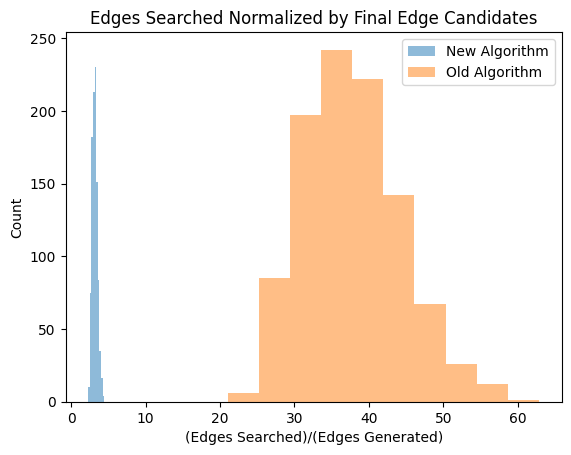

In [10]:
plt.hist(percent_search, alpha=0.5, label='New Algorithm')
plt.hist(brute_percent_search, alpha=0.5, label='Old Algorithm')

plt.title('Edges Searched Normalized by Final Edge Candidates')
plt.ylabel('Count')
plt.xlabel('(Edges Searched)/(Edges Generated)')
plt.legend()

Text(0.5, 0, '(Edges Searched)/(Edges Generated)')

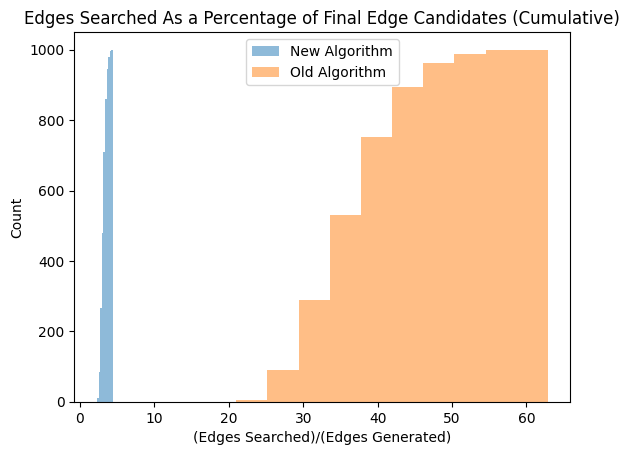

In [11]:
plt.hist(percent_search, alpha=0.5, label='New Algorithm', cumulative=True)
plt.hist(brute_percent_search, alpha=0.5, label='Old Algorithm', cumulative=True)
plt.title('Edges Searched As a Percentage of Final Edge Candidates (Cumulative)')

plt.legend()
plt.ylabel('Count')
plt.xlabel('(Edges Searched)/(Edges Generated)')

Text(0, 0.5, 'Count')

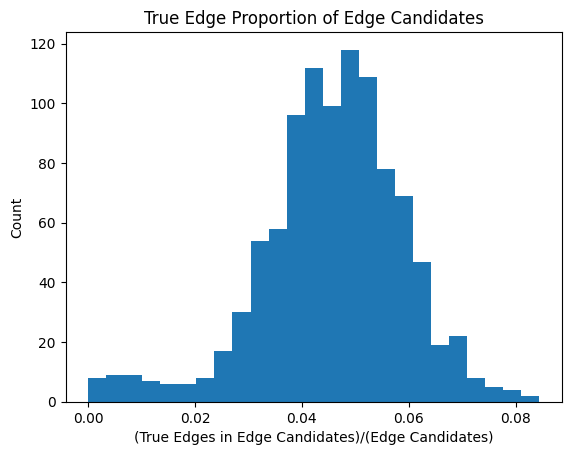

In [12]:
plt.hist(percent_true_edge, bins=25)
plt.title('True Edge Proportion of Edge Candidates')
plt.xlabel('(True Edges in Edge Candidates)/(Edge Candidates)')
plt.ylabel('Count')

Text(0.5, 1.0, 'Proportion of All Possible True Edges Captured')

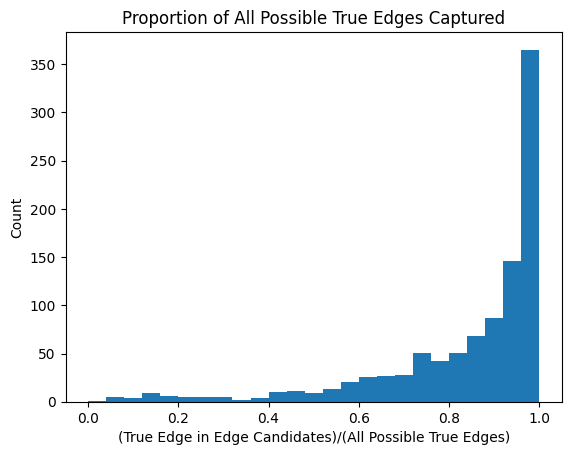

In [13]:
plt.hist(percent_all_edge, bins=25)
plt.xlabel('(True Edge in Edge Candidates)/(All Possible True Edges)')
plt.ylabel('Count')
plt.title('Proportion of All Possible True Edges Captured')


In [ ]:
plt.hist(percent_search, bins=15)
plt.title('Searched Compared To Total Edges')
plt.ylabel('Count')
plt.xlabel('Searched')

Text(0.5, 0, 'Searched')

In [28]:
f['edge_index'].shape[1]

104

In [25]:
list(f.keys())

['hit_cartesian',
 'hit_cylindrical',
 'layer_id',
 'n_pixels',
 'energy',
 'momentum',
 'interaction_point',
 'trigger',
 'has_trigger_pair',
 'track_origin',
 'edge_index',
 'edge_z0',
 'edge_phi_slope',
 'phi_slope_max',
 'z0_max',
 'trigger_node',
 'particle_id',
 'particle_type',
 'parent_particle_type']